# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try and compare South Africa's two biggest cities, namely Johannesburg and Cape Town.
This report is targeted at tourism businesses but can be used to inform a variety of business and or lifestyle decisions.

We will attempt to **classify all neighborhoods for both cities collectively** by analysing their **venue composition**.
Once the neighborhoods have been classified we can **review the distribution of these classes across the two cities**.

Reviewing the distribution of neighborhood classes will hopefully reveal an additional layer of insight that can be used to inform the structuring of tourism packages. This will also give a general idea of how the lifestyle for the areas would be similar or differ from city to city.

## Data <a name="data"></a>

A description of the data and how it will be used to solve the problem. 

Following data sources will be needed to extract/generate the required information:
- List of neighborhoods for each city (collected from Wikipedia)
- List of coordinates for each neighborhood (collected using Geopy Nominatim Module)
- List of venues for each neighborhood including their associated category (collected using FourSquare API)

Once the data is obtained we will need to perform the following analysis:
- Classify all neighborhoods, collectively, in terms of venue composition using Kmeans clustering
- Analyse the distribution of the neighborhood classes across the two cities to gauge similarity
- Plot the neighborhoods on a map to view the geographical distribution of the neighborhood classes

In [33]:
# FourSquare API information

api_secretspath = r'C:\Temp\FourSquare_AppSecret.txt'

with open(api_secretspath, "r") as secret_content:
    lines = secret_content.readlines()
    
CLIENT_ID = lines[0].rstrip() # Foursquare ID
CLIENT_SECRET = lines[1].rstrip() #Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [2]:
# Module Imports
import requests # library to handle requests
import numpy as np # useful for many scientific computing in Python
import pandas as pd # primary data structure library

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

from sklearn.cluster import KMeans # import k-means from clustering stage

# Matplotlib and associated plotting modules
import folium # Geographic plotting library
from matplotlib import pyplot as plt # Plotting library
import matplotlib.cm as cm # Module used for generating colors
import matplotlib.colors as colors # Module used for generating colors

### Getting a list of neighborhoods per city

The below links contain the information required.
- https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs
- https://en.wikipedia.org/wiki/Suburbs_of_Johannesburg

The data is unfortunately not very well structured. It was decided to manually extract the list of neighborhoods and save them into text files which could then be imported. Along with saving the neighborhood names, the city was appended after a comma to facilitate the coordinate lookups.

In [7]:
# Reading in list of neighborhoods from text files

# Creating empty list
cpt_suburbs = []

# File Paths
cpt_listpath = r"Data\CapeTown_neighbourhood.txt"

# Open the files and read in the data
with open(cpt_listpath, "r") as cpt_content:
    lines = cpt_content.readlines()
    for l in lines:
        cpt_suburbs.append(l)

# Display sample of the lists
print('Cape Town - First 5 Neigborhoods of {}'.format(len(cpt_suburbs)))
cpt_suburbs[0:4]

Cape Town - First 5 Neigborhoods of 135


['Athlone, Cape Town\n',
 'Atlantis, Cape Town\n',
 'Bakoven, Cape Town\n',
 'Bantry Bay, Cape Town\n']

In [6]:
# Reading in list of neighborhoods from text files

# Creating empty list
jhb_suburbs = []

# File Paths
jhb_listpath = r"Data\Johannesburg_neighbourhood.txt"

with open(jhb_listpath, "r") as jhb_content:
    lines = jhb_content.readlines()
    for l in lines:
        jhb_suburbs.append(l)

print('Johannesburg - First 5 Neigborhoods of {}'.format(len(jhb_suburbs)))
jhb_suburbs[0:5]

Johannesburg - First 5 Neigborhoods of 358


['Abbotsford, Johannesburg\n',
 'Aeroton, Johannesburg\n',
 'Airdlin, Johannesburg\n',
 'Alan Manor, Johannesburg\n',
 'Albertskroon, Johannesburg\n']

### Adding longitude and latitude coordinates for all the neighborhoods

Now that we have a list of all the neighborhoods, we need to find their coordinates.
We will make use of the Nominatim module to do this.

As the data source is likely to not be accurate, we will also be gathering actual addresses along with coordinates.
This data will be used to ensure we have good information before performing any analysis.

In [11]:
# function for getting location information and coordinates
def get_locdata(searchstring):
    
    result = {}
       
    print("Searching : {}".format(searchstring)) # print information to keep track of progress
    
    try:
        geolocator = Nominatim(user_agent="sa_explorer")
        location = geolocator.geocode(searchstring)
        
        result['searchstring'] = searchstring
        result['address'] = location.address
        result['longitude'] = location.longitude
        result['latitude'] = location.latitude
    
    except: # unable to gather information, store None Values
        
        result['searchstring'] = searchstring
        result['address'] = None
        result['longitude'] = None
        result['latitude'] = None
        
    return result


In [12]:
# Gathering Location information

# Merge list of neighborhoods to be searched  
all_suburbs = cpt_suburbs + jhb_suburbs

# Create empty list to capture results of the searches
locdata = []

for loc in all_suburbs:
    locdata.append(get_locdata(loc.rstrip()))

Searching : Athlone, Cape Town
Searching : Atlantis, Cape Town
Searching : Bakoven, Cape Town
Searching : Bantry Bay, Cape Town
Searching : Belhar, Cape Town
Searching : Bellville, Cape Town
Searching : Bergvliet, Cape Town
Searching : Bishop Lavis, Cape Town
Searching : Bishopscourt, Cape Town
Searching : Bloubergstrand, Cape Town
Searching : Bo-Kaap, Cape Town
Searching : Bonteheuwel, Cape Town
Searching : Bothasig, Cape Town
Searching : Brackenfell, Cape Town
Searching : Brooklyn, Cape Town
Searching : Camps Bay, Cape Town
Searching : Capri Village, Cape Town
Searching : Claremont, Cape Town
Searching : Clifton, Cape Town
Searching : Clovelly, Cape Town
Searching : Constantia, Cape Town
Searching : Crawford, Cape Town
Searching : Crossroads, Cape Town
Searching : Darling, Cape Town
Searching : De Waterkant, Cape Town
Searching : Delft, Cape Town
Searching : Devil's Peak Estate, Cape Town
Searching : Diep River, Cape Town
Searching : Durbanville, Cape Town
Searching : Edgemead, Cape 

Searching : Emmarentia, Johannesburg
Searching : Ennerdale, Johannesburg
Searching : Epsom Downs, Johannesburg
Searching : Erand, Johannesburg
Searching : Evans Park, Johannesburg
Searching : Fairland, Johannesburg
Searching : Fairview, Johannesburg
Searching : Fairway, Johannesburg
Searching : Fairwood, Johannesburg
Searching : Farmall, Johannesburg
Searching : Fellside, Johannesburg
Searching : Ferndale, Johannesburg
Searching : Ferreirasdorp, Johannesburg
Searching : Florida, Johannesburg
Searching : Florida Glen, Johannesburg
Searching : Florida Hills, Johannesburg
Searching : Fontainebleau, Johannesburg
Searching : Forbesdale, Johannesburg
Searching : Fordsburg, Johannesburg
Searching : Forest Hill, Johannesburg
Searching : Forest Town, Johannesburg
Searching : Fourways, Johannesburg
Searching : Framton, Johannesburg
Searching : Gallo Manor, Johannesburg
Searching : Gillview, Johannesburg
Searching : Glen Athol, Johannesburg
Searching : Glen Austin, Johannesburg
Searching : Glenad

Searching : Steeledale, Johannesburg
Searching : Strathavon, Johannesburg
Searching : Strijdompark, Johannesburg
Searching : Suideroord, Johannesburg
Searching : Sunningdale, Johannesburg
Searching : Sunningdale Ridge, Johannesburg
Searching : Sunninghill, Johannesburg
Searching : Sunrella, Johannesburg
Searching : Sunset Acres, Johannesburg
Searching : Sydenham, Johannesburg
Searching : The Gables, Johannesburg
Searching : The Gardens, Johannesburg
Searching : The Hill, Johannesburg
Searching : Theta, Johannesburg
Searching : Towerby, Johannesburg
Searching : Townsview, Johannesburg
Searching : Trevallyn, Johannesburg
Searching : Trojan, Johannesburg
Searching : Troyeville, Johannesburg
Searching : Tulisa Park, Johannesburg
Searching : Turf Club, Johannesburg
Searching : Turffontein, Johannesburg
Searching : Vandia Grove, Johannesburg
Searching : Victoria, Johannesburg
Searching : Village Main, Johannesburg
Searching : Vorna Valley, Johannesburg
Searching : Vrededorp, Johannesburg
Sea

In [21]:
# Convert the list of dictionaries to a dataframe
loc_df = pd.DataFrame(locdata)

# Display some high level information of the dataframe
print('dataframe shape')
loc_df.shape

dataframe shape


(493, 4)

In [22]:
print('dataframe head')
loc_df.head()

dataframe head


,searchstring,address,longitude,latitude
0,"Athlone, Cape Town","Athlone, Cape Town Ward 49, Cape Town, City of...",18.505000,-33.966667
1,"Atlantis, Cape Town","Atlantis, City of Cape Town, Western Cape, Sou...",18.500278,-33.567222
2,"Bakoven, Cape Town","Bakoven, Camps Bay, Cape Town, City of Cape To...",18.382778,-33.960000
3,"Bantry Bay, Cape Town","Bantry Bay, Cape Town, City of Cape Town, West...",18.378970,-33.928151
4,"Belhar, Cape Town","Belhar, Cape Town Ward 22, City of Cape Town, ...",18.625833,-33.944722


### Cleaning the location dataframe

There are unfortunately problems with the dataset.
- locations that could not be found
- locations that were found but aren't the ones intended (other countries)
- searchstring and address columns are actually not needed post cleanup

In [25]:
# Cleaning location dataframe

# Filter out locations that could not be found
loc_df = loc_df.dropna()

# Filter out results that are not in South Africa
loc_df = loc_df[ loc_df.address.str.contains("South Africa") ]

# Adding two new columns to the existing dataframe. for city and neighbourhood based on the searchstring
loc_df[['neighborhood','city']] = loc_df.searchstring.str.split(", ",expand=True)

# Remove searchstring and address columns as they are no longer needed.
# This will be the baseline location data that we will use for analysis.
loc_df = loc_df.drop(columns=['address', 'searchstring'])

# reset the index
loc_df.reset_index(inplace=True,drop=True)

In [26]:
# Display some high level information of the dataframe
print('dataframe shape')
loc_df.shape

dataframe shape


(408, 4)

In [27]:
print('dataframe head')
loc_df.head()

dataframe head


,longitude,latitude,neighborhood,city
0,18.505000,-33.966667,Athlone,Cape Town
1,18.500278,-33.567222,Atlantis,Cape Town
2,18.382778,-33.960000,Bakoven,Cape Town
3,18.378970,-33.928151,Bantry Bay,Cape Town
4,18.625833,-33.944722,Belhar,Cape Town


### Exploring the Venues in all the neighborhoods

Now that we have a dataframe with the neighborhoods and coordinates, it is time to add all the nearby venues.
We will be using the FourSquare API to gather this information.

In [29]:
# Define function for exploring a location for all nearby venues
def getNearbyVenues(neighborhoods, cities, latitudes, longitudes):

    venues_list=[]
    for neighborhood, city, lat, lng in zip(neighborhoods, cities, latitudes, longitudes):
        print("Exploring : {} - {}".format(city, neighborhood).rstrip()) # Print current search to track progress
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighborhood,
            city,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'City', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [37]:
# Gather all venues into a dataframe
all_venues = getNearbyVenues(neighborhoods = loc_df['neighborhood'],
                             cities = loc_df['city'], 
                             latitudes = loc_df['latitude'],
                             longitudes = loc_df['longitude']
                             )

Exploring : Cape Town - Athlone
Exploring : Cape Town - Atlantis
Exploring : Cape Town - Bakoven
Exploring : Cape Town - Bantry Bay
Exploring : Cape Town - Belhar
Exploring : Cape Town - Bellville
Exploring : Cape Town - Bergvliet
Exploring : Cape Town - Bishop Lavis
Exploring : Cape Town - Bishopscourt
Exploring : Cape Town - Bloubergstrand
Exploring : Cape Town - Bo-Kaap
Exploring : Cape Town - Bonteheuwel
Exploring : Cape Town - Bothasig
Exploring : Cape Town - Brackenfell
Exploring : Cape Town - Brooklyn
Exploring : Cape Town - Camps Bay
Exploring : Cape Town - Capri Village
Exploring : Cape Town - Claremont
Exploring : Cape Town - Clifton
Exploring : Cape Town - Clovelly
Exploring : Cape Town - Constantia
Exploring : Cape Town - Crawford
Exploring : Cape Town - Crossroads
Exploring : Cape Town - Darling
Exploring : Cape Town - De Waterkant
Exploring : Cape Town - Delft
Exploring : Cape Town - Devil's Peak Estate
Exploring : Cape Town - Diep River
Exploring : Cape Town - Durbanvill

Exploring : Johannesburg - Glenhazel
Exploring : Johannesburg - Glenvista
Exploring : Johannesburg - Greenside
Exploring : Johannesburg - Greenstone Hill
Exploring : Johannesburg - Gresswold
Exploring : Johannesburg - Greymont
Exploring : Johannesburg - Haddon
Exploring : Johannesburg - Headway Hill
Exploring : Johannesburg - Heriotdale
Exploring : Johannesburg - Highlands
Exploring : Johannesburg - Highlands North
Exploring : Johannesburg - Hillbrow
Exploring : Johannesburg - Homestead Park
Exploring : Johannesburg - Hurlingham
Exploring : Johannesburg - Hurlingham Gardens
Exploring : Johannesburg - Hyde Park
Exploring : Johannesburg - Illovo
Exploring : Johannesburg - Inanda
Exploring : Johannesburg - Ivory Park
Exploring : Johannesburg - Jeppestown
Exploring : Johannesburg - Jeppestown South
Exploring : Johannesburg - Johannesburg North
Exploring : Johannesburg - Joubert Park
Exploring : Johannesburg - Judith's Paarl
Exploring : Johannesburg - Jukskei Park
Exploring : Johannesburg -

In [38]:
# Need to create a key based on city and neighborhood as an index
all_venues['ID'] = all_venues['City'] + '_' + all_venues['Neighborhood']

In [39]:
print('dataframe head')
all_venues.head()

dataframe head


,Neighborhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,ID
0,Athlone,Cape Town,-33.966667,18.505,Wembley Roadhouse,-33.965429,18.514660,Burger Joint,Cape Town_Athlone
1,Athlone,Cape Town,-33.966667,18.505,Common Ground Cafe,-33.958918,18.485833,Coffee Shop,Cape Town_Athlone
2,Athlone,Cape Town,-33.966667,18.505,Western Province Cricket Club,-33.973314,18.482350,Athletics & Sports,Cape Town_Athlone
3,Athlone,Cape Town,-33.966667,18.505,Rondebosch Common,-33.959344,18.484840,Park,Cape Town_Athlone
4,Athlone,Cape Town,-33.966667,18.505,Starlings,-33.980100,18.481972,Café,Cape Town_Athlone


## Methodology <a name="methodology"></a>

Now that we have gathered all the required data, it is time to analyze it.

We will firstly need to classify all neighborhoods, collectively, in terms of venue composition using Kmeans clustering.
The neighborhoods are being classified collectively so that they have a basis for comparison.
We are using Kmeans clustering as there are no specific criteria around how the clustering need be done, for now at least.

Once we have all the neighborhoods classified, we can then analyze the distribution of these clusters across the two cities.
This will give us an idea of how similar/dissimilar the cities are.

Finally we will plot the neighborhoods back onto a map of each city to view the geographical distribution of the clusters.
Assuming that the clustering has run successfully we should find that these clusters will also reflect some level of geographic similarity.

## Analysis <a name="analysis"></a>

In [3]:
# Let's check how many venues were returned for each neighborhood
all_venues.groupby('ID').count()

,Neighborhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ID,,,,,,,,
Cape Town_Athlone,100,100,100,100,100,100,100,100
Cape Town_Atlantis,7,7,7,7,7,7,7,7
Cape Town_Bakoven,49,49,49,49,49,49,49,49
Cape Town_Bantry Bay,100,100,100,100,100,100,100,100
Cape Town_Belhar,67,67,67,67,67,67,67,67
...,...,...,...,...,...,...,...,...
Johannesburg_Woodmead,100,100,100,100,100,100,100,100
Johannesburg_Wynberg,100,100,100,100,100,100,100,100
Johannesburg_Yeoville,100,100,100,100,100,100,100,100


##### Note :
As you an see, some areas have returned the maximum limit of venues per API call, namely 100.
If more detailed classification is needed, it would be good to find more data. This is outside of the scope of this project though, as this may involve additional costs or smart management of queries and results to build the dataset.

For the time being, 100 venues for a neighborhood should provide enough information for classification to be performed.

In [5]:
# Let's check how many venues were returned for Cape Town
print('Venues in Cape Town : {}'.format(all_venues[(all_venues['City'] == 'Cape Town')].shape[0]))

Venues in Cape Town : 11355


In [6]:
# Let's check how many venues were returned for Johannesburg
print('Venues in Johannesburg : {}'.format(all_venues[(all_venues['City'] == 'Johannesburg')].shape[0]))

Venues in Johannesburg : 24301


In [4]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(all_venues['Venue Category'].unique())))

There are 280 uniques categories.


#### Clustering

In [7]:
# set up one hot encoding
venue_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

In [8]:
# let's examine the new dataframe size
venue_onehot.shape

(35656, 280)

In [9]:
# add ID column back to dataframe
venue_onehot['ID'] = all_venues['ID'] 

# confirm neighborhood info is in dataframe
venue_onehot['ID'].head()

0    Cape Town_Athlone
1    Cape Town_Athlone
2    Cape Town_Athlone
3    Cape Town_Athlone
4    Cape Town_Athlone
Name: ID, dtype: object

In [10]:
# let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
venue_grouped = venue_onehot.groupby('ID').mean().reset_index()

In [12]:
# Let us have a look at the dataframe
venue_grouped.head()

,ID,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Cape Town_Athlone,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0
1,Cape Town_Atlantis,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,Cape Town_Bakoven,0.020408,0.000000,0.000000,0.0,0.020408,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,Cape Town_Bantry Bay,0.010000,0.000000,0.000000,0.0,0.010000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,Cape Town_Belhar,0.014925,0.014925,0.044776,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Drop neighborhood column for clustering to be done (the new dataframe is no longer location aware)
venue_grouped_clustering = venue_grouped.drop('ID', 1)

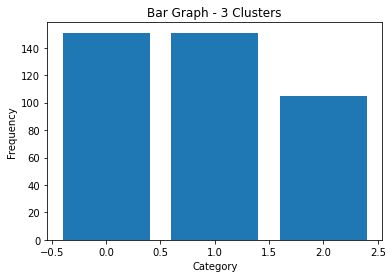

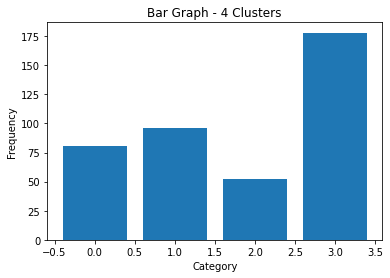

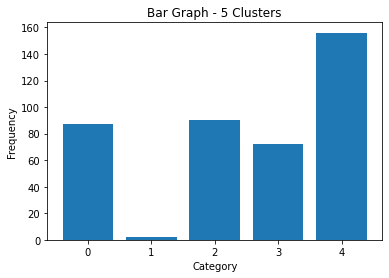

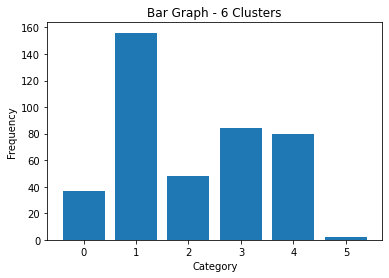

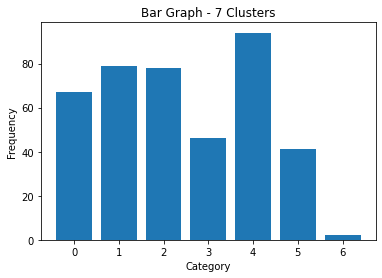

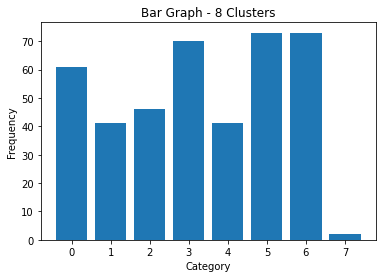

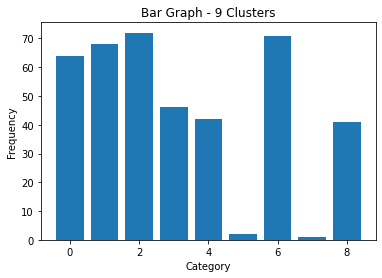

In [14]:
# Iterate through a number of clusters and perform KMeans Clustering to find optimal cluster volume
for kn in range(3,10):
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=kn, random_state=0).fit(venue_grouped_clustering)
    
    # extract unique values and frequency
    unique, frequency = np.unique(kmeans.labels_, return_counts = True)
    
    # Plot the distribution of classifications
    plt.bar(unique, frequency, align = 'center') 
    plt.title('Bar Graph - {} Clusters'.format(kn)) 
    plt.ylabel('Frequency') 
    plt.xlabel('Category')  
    
    plt.show()


##### Clustering Notes :

At 4 clusters we have about 50 neighborhoods in each cluster.

Above 5 clusters have an outlier cluster, which is not ideal, but can still be used.

At 9 clusters we introduce another outlier cluster, this feels like too many clusters.

To progress the analysis we will make use of 8 clusters, which seems like a good distribution.


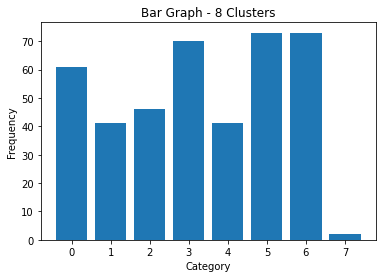

In [15]:
# Plotting for 8 clusters

# run k-means clustering
kmeans = KMeans(n_clusters=8, random_state=0).fit(venue_grouped_clustering)

# extract unique values and frequency
unique, frequency = np.unique(kmeans.labels_, return_counts = True)

# Plot the distribution of classifications
plt.bar(unique, frequency, align = 'center') 
plt.title('Bar Graph - {} Clusters'.format(8)) 
plt.ylabel('Frequency') 
plt.xlabel('Category')  

plt.show()

#### Finding the most prominent venues per neighborhood

In [16]:
# let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ID']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe with neighborhoods
ID_venues_sorted = pd.DataFrame(columns=columns)
ID_venues_sorted['ID'] = venue_grouped['ID']

In [18]:
# add most common venues
for ind in np.arange(venue_grouped.shape[0]):
    ID_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_grouped.iloc[ind, :], num_top_venues)

# Display the dataframe
ID_venues_sorted.head()

,ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cape Town_Athlone,Coffee Shop,Café,Thai Restaurant,Pizza Place,Grocery Store,Bakery,Italian Restaurant,Ice Cream Shop,Seafood Restaurant,Shopping Mall
1,Cape Town_Atlantis,Comfort Food Restaurant,Paintball Field,Farm,Fried Chicken Joint,Business Service,Zoo,Food Court,Flower Shop,Food,Food & Drink Shop
2,Cape Town_Bakoven,Hotel,Beach,Scenic Lookout,Café,Park,Restaurant,Coffee Shop,Mountain,Burger Joint,Bed & Breakfast
3,Cape Town_Bantry Bay,Hotel,Beach,Restaurant,Seafood Restaurant,Park,Bar,Coffee Shop,Trail,Ice Cream Shop,Café
4,Cape Town_Belhar,Fast Food Restaurant,Hotel,Breakfast Spot,Shopping Mall,Grocery Store,Rental Car Location,Coffee Shop,Steakhouse,Airport Lounge,Convenience Store


#### Adding the cluster labels back into the venue analysis

In [21]:
# add clustering labels
ID_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Create a new dataframe from base location dataframe
ID_venues_merged = loc_df

# Add back in the ID to be used as a key
# Need to create a key based on city and neighborhood as an index
ID_venues_merged['ID'] = ID_venues_merged['city'] + '_' + ID_venues_merged['neighborhood']

# Add all the most common venues by neighborhood
ID_venues_merged = ID_venues_merged.join(ID_venues_sorted.set_index('ID'), on='ID')

ID_venues_merged.head()

,longitude,latitude,neighborhood,city,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,18.505000,-33.966667,Athlone,Cape Town,Cape Town_Athlone,6,Coffee Shop,Café,Thai Restaurant,Pizza Place,Grocery Store,Bakery,Italian Restaurant,Ice Cream Shop,Seafood Restaurant,Shopping Mall
1,18.500278,-33.567222,Atlantis,Cape Town,Cape Town_Atlantis,7,Comfort Food Restaurant,Paintball Field,Farm,Fried Chicken Joint,Business Service,Zoo,Food Court,Flower Shop,Food,Food & Drink Shop
2,18.382778,-33.960000,Bakoven,Cape Town,Cape Town_Bakoven,0,Hotel,Beach,Scenic Lookout,Café,Park,Restaurant,Coffee Shop,Mountain,Burger Joint,Bed & Breakfast
3,18.378970,-33.928151,Bantry Bay,Cape Town,Cape Town_Bantry Bay,0,Hotel,Beach,Restaurant,Seafood Restaurant,Park,Bar,Coffee Shop,Trail,Ice Cream Shop,Café
4,18.625833,-33.944722,Belhar,Cape Town,Cape Town_Belhar,5,Fast Food Restaurant,Hotel,Breakfast Spot,Shopping Mall,Grocery Store,Rental Car Location,Coffee Shop,Steakhouse,Airport Lounge,Convenience Store


#### Clustering Labels
The clustering is unsupervised, so the labels are numeric.

Below is my attempt to describe the clusters by assigning a more meaningful name.

- Cluster 0 - Hospitality orientated area (Hotels, high-end restaurants, coffee shops)
- Cluster 1 - Fast Food area (Fast food and retail)
- Cluster 2 - Social area (Coffee Shops, Fast food, Art)
- Cluster 3 - Retail area (Shopping malls, grocey stores)
- Cluster 4 - Tourist Destination (Veriety of restaurants, includes beaches)
- Cluster 5 - Entertainment area (Restaurants and retail)
- Cluster 6 - Coffee/Cafe Area
- Cluster 7 - Outlying Area

In [22]:
# Renaming clusters to soomething more meaningful
ID_venues_merged['Cluster Labels'] = ID_venues_merged['Cluster Labels'].map(
            {0:'Hospitality',
             1:'FastFood',
             2:'Social',
             3:'Retail',
             4:'Tourism',
             5:'Entertainment',
             6:'Cafe',
             7:'Outlying'
             }
        )

ID_venues_merged.head()

,longitude,latitude,neighborhood,city,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,18.505000,-33.966667,Athlone,Cape Town,Cape Town_Athlone,Cafe,Coffee Shop,Café,Thai Restaurant,Pizza Place,Grocery Store,Bakery,Italian Restaurant,Ice Cream Shop,Seafood Restaurant,Shopping Mall
1,18.500278,-33.567222,Atlantis,Cape Town,Cape Town_Atlantis,Outlying,Comfort Food Restaurant,Paintball Field,Farm,Fried Chicken Joint,Business Service,Zoo,Food Court,Flower Shop,Food,Food & Drink Shop
2,18.382778,-33.960000,Bakoven,Cape Town,Cape Town_Bakoven,Hospitality,Hotel,Beach,Scenic Lookout,Café,Park,Restaurant,Coffee Shop,Mountain,Burger Joint,Bed & Breakfast
3,18.378970,-33.928151,Bantry Bay,Cape Town,Cape Town_Bantry Bay,Hospitality,Hotel,Beach,Restaurant,Seafood Restaurant,Park,Bar,Coffee Shop,Trail,Ice Cream Shop,Café
4,18.625833,-33.944722,Belhar,Cape Town,Cape Town_Belhar,Entertainment,Fast Food Restaurant,Hotel,Breakfast Spot,Shopping Mall,Grocery Store,Rental Car Location,Coffee Shop,Steakhouse,Airport Lounge,Convenience Store


#### Taking a closer look at the various clusters

In [23]:
# Cluster 0 - Hospitality orientated area (Hotels, high-end restaurants, coffee shops)
ID_venues_merged.loc[ID_venues_merged['Cluster Labels'] == 'Hospitality', ID_venues_merged.columns[[4] + list(range(5, 9))]]

,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,Cape Town_Bakoven,Hospitality,Hotel,Beach,Scenic Lookout
3,Cape Town_Bantry Bay,Hospitality,Hotel,Beach,Restaurant
15,Cape Town_Camps Bay,Hospitality,Hotel,Beach,Scenic Lookout
18,Cape Town_Clifton,Hospitality,Hotel,Beach,Restaurant
24,Cape Town_De Waterkant,Hospitality,Hotel,Café,Coffee Shop
...,...,...,...,...,...
372,Johannesburg_Strathavon,Hospitality,Hotel,Shopping Mall,Steakhouse
379,Johannesburg_The Gardens,Hospitality,Hotel,Coffee Shop,Italian Restaurant
399,Johannesburg_Wierda Valley,Hospitality,Hotel,Coffee Shop,Shopping Mall
401,Johannesburg_Woodlands,Hospitality,Coffee Shop,Hotel,Café


In [24]:
# Cluster 1 - Fast Food area (Fast food and retail)
ID_venues_merged.loc[ID_venues_merged['Cluster Labels'] == 'FastFood', ID_venues_merged.columns[[4] + list(range(5, 9))]]

,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
132,Johannesburg_Aeroton,FastFood,Fast Food Restaurant,Portuguese Restaurant,Shopping Mall
134,Johannesburg_Alan Manor,FastFood,Fast Food Restaurant,Portuguese Restaurant,Shopping Mall
177,Johannesburg_Chrisville,FastFood,Portuguese Restaurant,Fast Food Restaurant,Coffee Shop
186,Johannesburg_Crown Gardens,FastFood,Portuguese Restaurant,Fast Food Restaurant,Coffee Shop
192,Johannesburg_Diepkloof,FastFood,Fast Food Restaurant,African Restaurant,Portuguese Restaurant
194,Johannesburg_Dobsonville,FastFood,African Restaurant,Shopping Mall,Fast Food Restaurant
196,Johannesburg_Doornkop,FastFood,African Restaurant,Portuguese Restaurant,Gas Station
209,Johannesburg_Evans Park,FastFood,Coffee Shop,Portuguese Restaurant,Fast Food Restaurant
212,Johannesburg_Fairway,FastFood,Fast Food Restaurant,Portuguese Restaurant,Shopping Mall
219,Johannesburg_Forest Hill,FastFood,Portuguese Restaurant,Coffee Shop,Fast Food Restaurant


In [25]:
# Cluster 2 - Social area (Coffee Shops, Fast food, Art)
ID_venues_merged.loc[ID_venues_merged['Cluster Labels'] == 'Social', ID_venues_merged.columns[[4] + list(range(5, 9))]]

,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
138,Johannesburg_Alexandra,Social,Fast Food Restaurant,Coffee Shop,Hotel
139,Johannesburg_Amalgam,Social,Coffee Shop,Portuguese Restaurant,Theater
145,Johannesburg_Bellevue,Social,Fast Food Restaurant,Coffee Shop,Hotel
146,Johannesburg_Bellevue East,Social,Fast Food Restaurant,Coffee Shop,Hotel
148,Johannesburg_Benrose,Social,Fast Food Restaurant,Flower Shop,Portuguese Restaurant
150,Johannesburg_Berea,Social,Fast Food Restaurant,Café,Hotel
151,Johannesburg_Bertrams,Social,Coffee Shop,Fast Food Restaurant,Hotel
161,Johannesburg_Braamfontein,Social,Coffee Shop,Fast Food Restaurant,Portuguese Restaurant
178,Johannesburg_City Deep,Social,Coffee Shop,Fast Food Restaurant,Hotel
185,Johannesburg_Crown,Social,Coffee Shop,Portuguese Restaurant,Fast Food Restaurant


In [26]:
# Cluster 3 - Retail area (Shopping malls, grocey stores)
ID_venues_merged.loc[ID_venues_merged['Cluster Labels'] == 'Retail', ID_venues_merged.columns[[4] + list(range(5, 9))]]

,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
13,Cape Town_Brackenfell,Retail,Shopping Mall,Department Store,Grocery Store
66,Cape Town_Lotus River,Retail,Grocery Store,Café,Gas Station
96,Cape Town_Plattekloof,Retail,Grocery Store,Shopping Mall,Restaurant
133,Johannesburg_Airdlin,Retail,Shopping Mall,Pizza Place,Supermarket
144,Johannesburg_Barbeque Downs,Retail,Shopping Mall,Supermarket,Pizza Place
...,...,...,...,...,...
395,Johannesburg_Waterval Estate,Retail,Grocery Store,Coffee Shop,Indian Restaurant
396,Johannesburg_Weltevredenpark,Retail,Grocery Store,Fast Food Restaurant,Shopping Mall
400,Johannesburg_Witkoppen,Retail,Italian Restaurant,Shopping Mall,Coffee Shop
402,Johannesburg_Woodmead,Retail,Shopping Mall,Grocery Store,Restaurant


In [27]:
# Cluster 4 - Tourist Destination (Veriety of restaurants, includes beaches)
ID_venues_merged.loc[ID_venues_merged['Cluster Labels'] == 'Tourism', ID_venues_merged.columns[[4] + list(range(5, 9))]]

,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
6,Cape Town_Bergvliet,Tourism,Restaurant,Grocery Store,Coffee Shop
9,Cape Town_Bloubergstrand,Tourism,Beach,Seafood Restaurant,Café
19,Cape Town_Clovelly,Tourism,Café,Beach,Seafood Restaurant
20,Cape Town_Constantia,Tourism,Restaurant,Café,Coffee Shop
27,Cape Town_Diep River,Tourism,Restaurant,Café,Grocery Store
33,Cape Town_Firgrove,Tourism,Winery,Restaurant,Steakhouse
34,Cape Town_Fish Hoek,Tourism,Café,Beach,Coffee Shop
38,Cape Town_Glencairn,Tourism,Café,Seafood Restaurant,Beach
41,Cape Town_Grassy Park,Tourism,Café,Coffee Shop,Restaurant
46,Cape Town_Heathfield,Tourism,Restaurant,Café,Grocery Store


In [29]:
# Cluster 5 - Entertainment area (Restaurants and retail)
ID_venues_merged.loc[ID_venues_merged['Cluster Labels'] == 'Entertainment', ID_venues_merged.columns[[4] + list(range(5, 9))]]

,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
4,Cape Town_Belhar,Entertainment,Fast Food Restaurant,Hotel,Breakfast Spot
5,Cape Town_Bellville,Entertainment,Fast Food Restaurant,Restaurant,Grocery Store
7,Cape Town_Bishop Lavis,Entertainment,Fast Food Restaurant,Steakhouse,Hotel
11,Cape Town_Bonteheuwel,Entertainment,Fast Food Restaurant,Gas Station,Hotel
12,Cape Town_Bothasig,Entertainment,Grocery Store,Seafood Restaurant,Steakhouse
...,...,...,...,...,...
375,Johannesburg_Sunningdale Ridge,Entertainment,Shopping Mall,Coffee Shop,Burger Joint
378,Johannesburg_The Gables,Entertainment,Fast Food Restaurant,Shopping Mall,Portuguese Restaurant
383,Johannesburg_Townsview,Entertainment,Coffee Shop,Restaurant,Portuguese Restaurant
386,Johannesburg_Tulisa Park,Entertainment,Shopping Mall,Fast Food Restaurant,Gas Station


In [28]:
# Cluster 6 - Coffee/Cafe Area
ID_venues_merged.loc[ID_venues_merged['Cluster Labels'] == 'Cafe', ID_venues_merged.columns[[4] + list(range(5, 9))]]

,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Cape Town_Athlone,Cafe,Coffee Shop,Café,Thai Restaurant
8,Cape Town_Bishopscourt,Cafe,Café,Coffee Shop,Italian Restaurant
10,Cape Town_Bo-Kaap,Cafe,Café,Coffee Shop,Restaurant
14,Cape Town_Brooklyn,Cafe,Coffee Shop,Hotel,Café
16,Cape Town_Capri Village,Cafe,Café,Italian Restaurant,Coffee Shop
...,...,...,...,...,...
363,Johannesburg_Sophiatown,Cafe,Coffee Shop,Cocktail Bar,Pizza Place
380,Johannesburg_The Hill,Cafe,Coffee Shop,Restaurant,Italian Restaurant
393,Johannesburg_Vrededorp,Cafe,Coffee Shop,Bar,Portuguese Restaurant
397,Johannesburg_Westcliff,Cafe,Café,Restaurant,Cocktail Bar


In [30]:
# Cluster 7 - Outlying Area
ID_venues_merged.loc[ID_venues_merged['Cluster Labels'] == 'Outlying', ID_venues_merged.columns[[4] + list(range(5, 9))]]

,ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Cape Town_Atlantis,Outlying,Comfort Food Restaurant,Paintball Field,Farm
69,Cape Town_Mamre,Outlying,Music Venue,Business Service,Fried Chicken Joint


#### Plotting the cluster distribution

In [31]:
# Setting up info to be used in upcoming plots

# Define labels based on the cluster labels assigned (List is manually ordered)
labels = ['Cafe', 'Entertainment', 'Retail', 'Hospitality', 'Social', 'FastFood', 'Tourism', 'Outlying']

# Get totals
cpt_total = ID_venues_merged[(ID_venues_merged['city'] == 'Cape Town')].shape[0]
jhb_total = ID_venues_merged[(ID_venues_merged['city'] == 'Johannesburg')].shape[0]

# Build counts for plotting
cpt_count = []
jhb_count = []
cpt_perc = []
jhb_perc = []

for label in labels:
    cpt_count.append(ID_venues_merged[(ID_venues_merged['city'] == 'Cape Town') & (ID_venues_merged['Cluster Labels'] == label)].shape[0])
    jhb_count.append(ID_venues_merged[(ID_venues_merged['city'] == 'Johannesburg') & (ID_venues_merged['Cluster Labels'] == label)].shape[0])
    
    cpt_perc.append(ID_venues_merged[(ID_venues_merged['city'] == 'Cape Town') & (ID_venues_merged['Cluster Labels'] == label)].shape[0] / cpt_total)
    jhb_perc.append(ID_venues_merged[(ID_venues_merged['city'] == 'Johannesburg') & (ID_venues_merged['Cluster Labels'] == label)].shape[0] / jhb_total)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

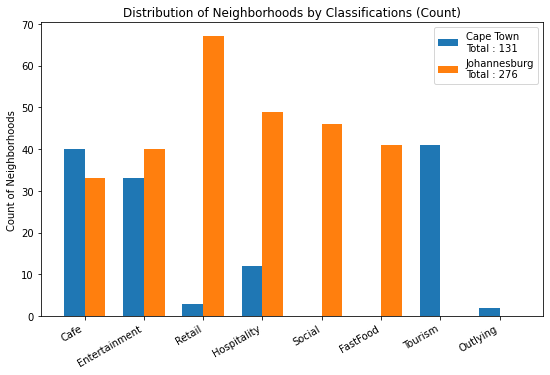

In [32]:
# Plot Count Comparison

fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(6)

rects1 = ax.bar(x - width/2, cpt_count, width, label='Cape Town\nTotal : {}'.format(cpt_total))
rects2 = ax.bar(x + width/2, jhb_count, width, label='Johannesburg\nTotal : {}'.format(jhb_total))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count of Neighborhoods')
ax.set_title('Distribution of Neighborhoods by Classifications (Count)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

fig.autofmt_xdate()

plt.show()

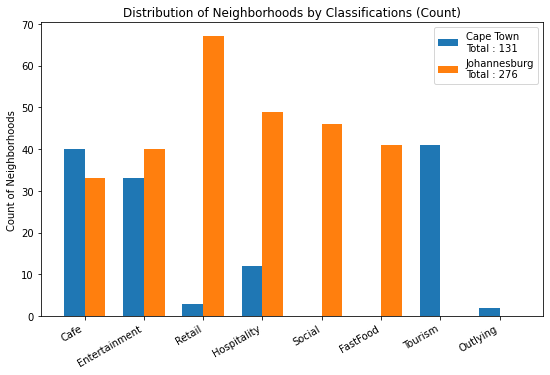

In [33]:
# Plot Percentage Comparison

fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(6)

rects1 = ax.bar(x - width/2, cpt_count, width, label='Cape Town\nTotal : {}'.format(cpt_total))
rects2 = ax.bar(x + width/2, jhb_count, width, label='Johannesburg\nTotal : {}'.format(jhb_total))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count of Neighborhoods')
ax.set_title('Distribution of Neighborhoods by Classifications (Count)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

fig.autofmt_xdate()

plt.show()

#### Visualizing the geographic distribution of the clusters

In [34]:
# Setting up info to be used in upcoming plots

# Coordiates to be used as the centerpoints for the maps.
cpt_lat, cpt_long = -33.918861, 18.423300
jhb_lat, jhb_long = -26.195246, 28.034088

# Split the data sets
cpt_merged = ID_venues_merged[(ID_venues_merged['city'] == 'Cape Town')]
jhb_merged = ID_venues_merged[(ID_venues_merged['city'] == 'Johannesburg')]

# set color scheme for the clusters
kclusters = 8 # number of clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Assign colors to a dictionary
clustercolors = {}
for label,i in zip(labels, range(kclusters)):
    clustercolors[label] = rainbow[i]

In [35]:
# create map for Cape Town
map_clusters = folium.Map(location=[cpt_lat, cpt_long], zoom_start=10)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cpt_merged['latitude'], cpt_merged['longitude'], cpt_merged['neighborhood'], cpt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=clustercolors[cluster],
        fill=True,
        fill_color=clustercolors[cluster],
        fill_opacity=0.7).add_to(map_clusters)

# Display the map
map_clusters

In [36]:
# create map for Johannesburg
map_clusters = folium.Map(location=[jhb_lat, jhb_long], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jhb_merged['latitude'], jhb_merged['longitude'], jhb_merged['neighborhood'], jhb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=clustercolors[cluster],
        fill=True,
        fill_color=clustercolors[cluster],
        fill_opacity=0.7).add_to(map_clusters)

# Display the map
map_clusters

Results section where you discuss the results.
Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
Conclusion section where you conclude the report.

## Results and Discussion <a name="results"></a>

The classification of the various neighborhoods seems to have been rather successful. This is in spite of the limits of the FourSquare API being reached, where the maximum venues returned per query is 100.
More detailed classification is likely, however for the 8 classifications generated are sufficient for our purposes.

Looking at the distribution of the clusters across the cities, Johannesburg and Cape Town are very different cities.
Johannesburg is more densely packed with venues compared to Cape Town.
Some classes of neighborhood are exclusive to either Cape Town or Johannesburg :

    Social & Fast Food : Only found in Johannesburg
    Tourism : Only found in Cape Town (Outlying classification ignored due to low volume)

Most classes of neighborhood, with the exception of cafe and entertainment, have very contrasting concentrations.

When plotting the neighborhoods geographically, we find there is a pattern to how they have been clustered.
This confirms the statement made previously that the classification of the neighborhoods was successful.


## Conclusion <a name="conclusion"></a>

In terms of venue composition, we have to conclude that Johannesburg and Cape Town are very different cities, but also share some similarity in areas.

Keeping in mind that this is only one point of view when comparing the two cities, there is now additional information available to inform future decision-making.

With this information it is definitely possible to build tourism packages across the two cities.
Tourists will generally enter South Africa in Johannesburg and then fly to Cape Town immediately.
Tourism packages can be structured to show-off some very contrasting experiences between the two cities.
This can be done by touring Johannesburg for a few days before moving to Cape Town to experience something different, potentially prolonging stays and associated revenue generation.

Details on how to leverage this information, and how they related to other data, will be left to the tourism trade.